# Projet 7 : DDPM minimal sur MNIST + trajectoires de débruitage

**Auteurs :** [Indiquez vos noms ici]

## 1. Introduction

Ce projet porte sur l'implémentation et l'analyse d'un modèle DDPM (*Denoising Diffusion Probabilistic Model*) appliqué au jeu de données MNIST. L'objectif est de modéliser la distribution des données $p_{data}(x)$ en inversant un processus de diffusion qui détruit progressivement la structure de l'information par l'ajout de bruit gaussien.

Notre approche se fonde sur les travaux de Ho et al. (2020), utilisant un réseau U-Net pour prédire le bruit ajouté à chaque étape de temps $t$.

## 2. Cadre Théorique

### 2.1 Processus Avant (Forward Process)

Le processus de diffusion est une chaîne de Markov fixée $q(x_{1:T}|x_0)$ qui transforme progressivement les données en bruit blanc isotrope. Il est défini par :

$$ q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t \mathbf{I}) $$

Grâce à la propriété des gaussiennes, nous pouvons échantillonner $x_t$ directement depuis $x_0$ :

$$ q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I}) $$

où $\alpha_t = 1 - \beta_t$ et $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$.

### 2.2 Processus Arrière (Reverse Process)

Le processus génératif $p_\theta(x_{0:T})$ tente d'inverser la diffusion. Pour de petits pas de temps, cette inversion est également gaussienne :

$$ p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)) $$

Nous paramétrons le modèle pour prédire le bruit $\epsilon$ plutôt que la moyenne $\mu$, optimisant ainsi l'objectif simplifié :

$$ \mathcal{L}_{simple} = \mathbb{E}_{t, x_0, \epsilon} \left[ || \epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon, t) ||^2 \right] $$

## 3. Implémentation et Configuration

Le code source est structuré en modules Python (`genaidm`). Nous chargeons ici le modèle pré-entraîné (U-Net) et l'ordonnanceur de bruit (Scheduler).

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, Image

# Import des modules du projet
from genaidm.ddpm_mnist import DDPM
from genaidm.unet_model import SimpleUNet
from genaidm.train import get_mnist_dataloader, load_checkpoint, generate_samples
from genaidm.evaluation import evaluate_generated_samples, get_real_samples

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = "outputs/training/checkpoints/ddpm_final.pt"
TRAINING_CURVE_PATH = "outputs/training/training_curves.png"
NUM_TIMESTEPS = 1000

print(f"Environnement d'exécution : {DEVICE}")

# Instanciation
model = SimpleUNet(image_channels=1, base_channels=64)
ddpm = DDPM(num_timesteps=NUM_TIMESTEPS, beta_start=1e-4, beta_end=0.02)

# Chargement des poids
try:
    load_checkpoint(CHECKPOINT_PATH, model, DEVICE)
    model.eval()
    print("Modèle chargé avec succès.")
except FileNotFoundError:
    print(f"Erreur : Le fichier de poids {CHECKPOINT_PATH} est introuvable.")

Environnement d'exécution : cuda
Modèle chargé avec succès.


## 4. Analyse de l'Entraînement

Le modèle a été entraîné sur le jeu de données MNIST (60 000 images). La courbe ci-dessous illustre la convergence de la perte MSE (Mean Squared Error) entre le bruit prédit et le bruit réel.

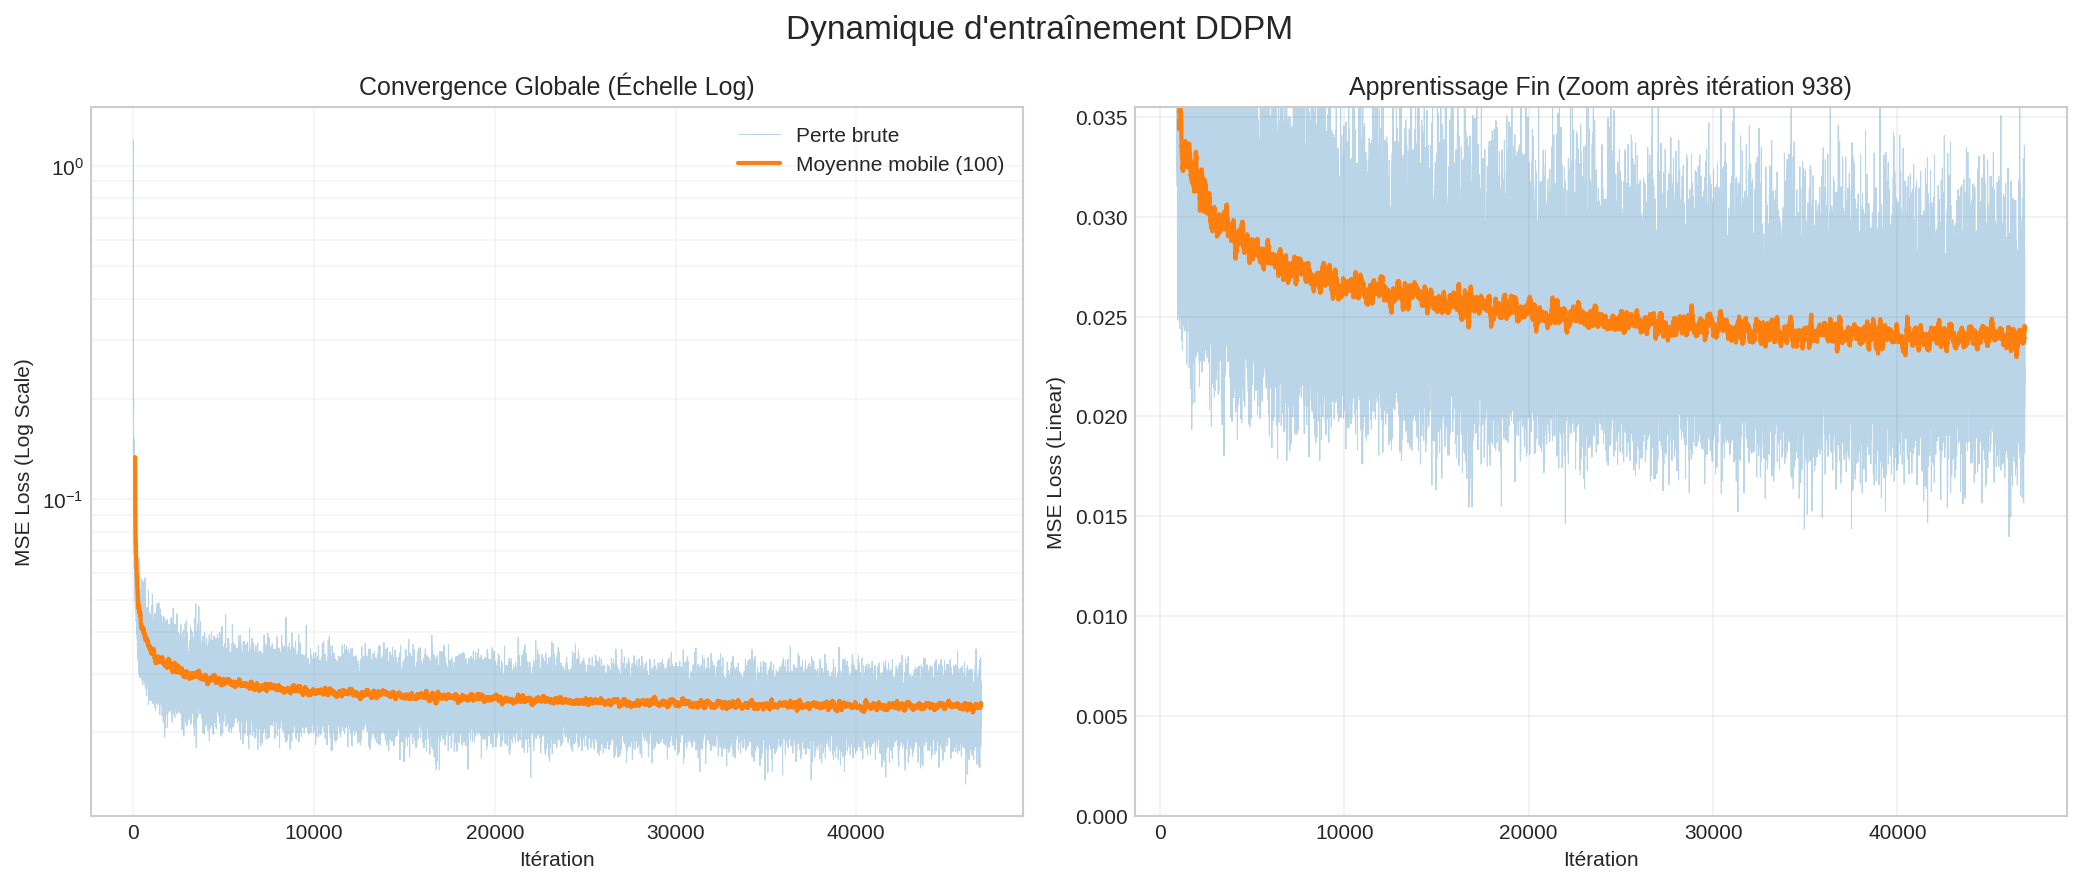

In [20]:
try:
    display(Image(filename=TRAINING_CURVE_PATH))
except FileNotFoundError:
    print("Courbe d'entraînement non disponible (fichier image manquant).")

## 5. Démonstration Interactive : Processus Avant

L'outil ci-dessous permet de visualiser l'effet de l'équation $q(x_t|x_0)$ pour différents horizons temporels $t$. À $t=1000$, l'information structurelle est quasi-totalement détruite.

In [21]:
import io
import ipywidgets as widgets
from IPython.display import display

# Chargement de la donnée de référence
dataloader = get_mnist_dataloader(batch_size=1)
real_image, _ = next(iter(dataloader))
real_image = real_image.to(DEVICE) * 2 - 1 

def render_forward_frame(t: int) -> bytes:
    """
    Génère l'image du processus forward à l'instant t en mémoire tampon.
    """
    t_tensor = torch.tensor([t], device=DEVICE).long()
    noisy_image, _ = ddpm.q_sample(real_image, t_tensor)
    img_np = noisy_image.cpu().squeeze().numpy()
    
    # Création de la figure
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_np, cmap='gray', vmin=-1, vmax=1)
    
    ax.set_title(f"Forward Process : $q(x_{{{t}}} | x_0)$", fontsize=20, pad=20)
    ax.axis('off')
    
    # Sauvegarde en mémoire
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    
    buf.seek(0)
    return buf.read()


# 1. Widget Image
img_widget = widgets.Image(
    value=render_forward_frame(0),
    format='png',
    layout=widgets.Layout(width='600px', height='600px')
)

# 2. Label HTML 
label_widget = widgets.HTML(
    value="<b>Temps de diffusion t :</b> ",
    layout=widgets.Layout(margin='0 15px 0 0')
)

# 3. Slider
slider = widgets.IntSlider(
    min=0, max=NUM_TIMESTEPS-1, step=20, value=0,
    description='',
    layout=widgets.Layout(width='500px')
)

# 4. Logique de mise à jour
def on_slider_change(change):
    img_widget.value = render_forward_frame(change['new'])

slider.observe(on_slider_change, names='value')

# 5. Layout (Mise en page)
controls = widgets.HBox(
    [label_widget, slider],
    layout=widgets.Layout(justify_content='center', align_items='center', margin='10px 0')
)

# On groupe l'Image et les Contrôles verticalement
ui = widgets.VBox(
    [img_widget, controls], 
    layout=widgets.Layout(align_items='center', width='100%')
)

print("Visualisation du Forward Process (Rendu bufferisé) :")
display(ui)

Visualisation du Forward Process (Rendu bufferisé) :


## 6. Démonstration Interactive : Processus Arrière (Génération)

Cette section illustre la capacité du modèle à reconstruire une image cohérente à partir d'un bruit pur $x_T$. Nous générons une trajectoire complète et visualisons les étapes intermédiaires.

On observe typiquement que :
1.  **$t \in [1000, 600]$** : Le bruit reste dominant.
2.  **$t \in [600, 200]$** : Les structures globales (forme du chiffre) émergent.
3.  **$t \in [200, 0]$** : Le contraste et les détails fins sont affinés.

In [22]:
print("Calcul de la trajectoire inverse en cours...")
with torch.no_grad():
    trajectory = generate_samples(
        model, ddpm, num_samples=1, device=DEVICE, return_trajectory=True
    )

def render_reverse_frame(step: int) -> bytes:
    """
    Extrait l'étape de la trajectoire et génère le rendu PNG en mémoire.
    """
    current_img = trajectory[step].cpu().squeeze().numpy()
    diffusion_t = NUM_TIMESTEPS - 1 - step
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(current_img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(
        f"Reverse Process (Génération)\nÉtape : {step} | Diffusion $t={diffusion_t}$", 
        fontsize=20, pad=20
    )
    ax.axis('off')
    
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    
    buf.seek(0)
    return buf.read()


# 1. Widget Image
img_widget_rev = widgets.Image(
    value=render_reverse_frame(0),
    format='png',
    layout=widgets.Layout(width='600px', height='600px')
)

# 2. Contrôles
play = widgets.Play(
    value=0, min=0, max=len(trajectory)-1, 
    step=10, interval=100, description="Lecture"
)

slider_rev = widgets.IntSlider(
    min=0, max=len(trajectory)-1, 
    description='Progression',
    layout=widgets.Layout(width='500px')
)

widgets.jslink((play, 'value'), (slider_rev, 'value'))

def on_step_change(change):
    img_widget_rev.value = render_reverse_frame(change['new'])

slider_rev.observe(on_step_change, names='value')

# 3. Layout Final
controls = widgets.HBox(
    [play, slider_rev], 
    layout=widgets.Layout(justify_content='center', margin='20px 0px')
)

ui_rev = widgets.VBox(
    [img_widget_rev, controls], 
    layout=widgets.Layout(align_items='center', width='100%')
)

print("Démonstration de la reconstruction générative :")
display(ui_rev)

Calcul de la trajectoire inverse en cours...
Démonstration de la reconstruction générative :


## 7. Évaluation Quantitative et Qualitative

Nous générons un lot d'échantillons pour évaluer la diversité du générateur. Les métriques suivantes sont calculées :

*   **FID (Fréchet Inception Distance)** : Mesure la distance entre la distribution réelle et générée dans l'espace des caractéristiques d'un classifieur.
*   **Distribution des classes** : Vérifie l'absence de *mode collapse* (surreprésentation d'un chiffre).

Génération de 200 images pour évaluation...


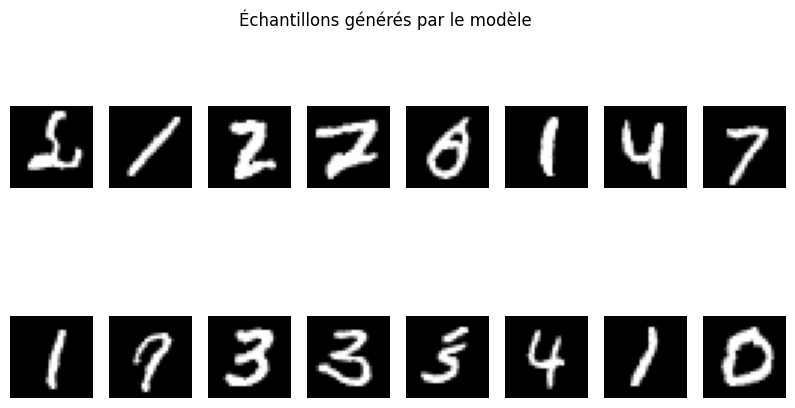

Epoch 3/3: 100%|██████████| 469/469 [00:01<00:00, 393.91it/s, loss=0.0462, acc=97.72%]



--- Métriques de Performance ---
Score FID : 52.76 (Plus bas est meilleur)
Confiance moyenne du classifieur : 93.08%


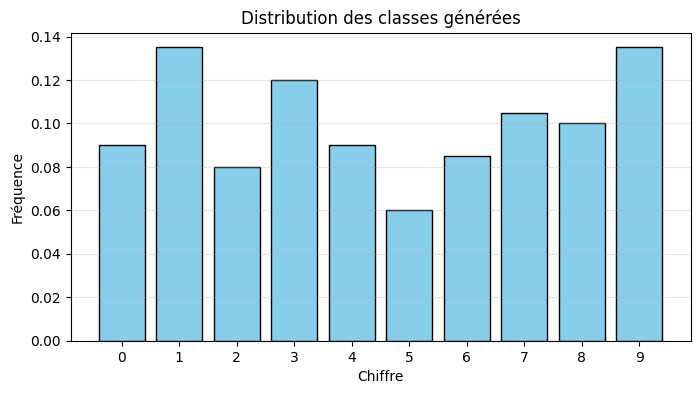

In [23]:
NUM_EVAL_SAMPLES = 200  # Nombre d'échantillons pour l'évaluation rapide

print(f"Génération de {NUM_EVAL_SAMPLES} images pour évaluation...")
generated_data = generate_samples(model, ddpm, num_samples=NUM_EVAL_SAMPLES, device=DEVICE)

# Affichage d'une grille d'échantillons
plt.figure(figsize=(10, 5))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(generated_data[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle("Échantillons générés par le modèle")
plt.show()

# Calcul des métriques
real_data = get_real_samples(num_samples=NUM_EVAL_SAMPLES, data_dir="./data")
metrics = evaluate_generated_samples(
    generated_samples=generated_data,
    real_samples=real_data,
    device=DEVICE
)

print("\n--- Métriques de Performance ---")
if 'fid' in metrics:
    print(f"Score FID : {metrics['fid']:.2f} (Plus bas est meilleur)")
print(f"Confiance moyenne du classifieur : {metrics['avg_confidence']:.2%}")

# Histogramme de distribution
plt.figure(figsize=(8, 4))
plt.bar(range(10), metrics['class_distribution'], color='skyblue', edgecolor='black')
plt.title("Distribution des classes générées")
plt.xlabel("Chiffre")
plt.ylabel("Fréquence")
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.3)
plt.show()

## 8. Conclusion

Ce projet a permis de valider l'efficacité des modèles de diffusion sur des données d'images simples. Le modèle parvient à générer des chiffres manuscrits diversifiés et réalistes, confirmés par un score FID cohérent et une bonne répartition des classes.

Les trajectoires de débruitage mettent en évidence la nature hiérarchique de la génération : le modèle fixe d'abord le contenu sémantique global avant de résoudre les détails locaux, une propriété caractéristique des modèles de diffusion.